# MNIST Rede dos anos 1980 - 1990

Dowload dataset:

In [ ]:
from google.colab import files
import os

if not os.path.isfile("MNIST.tgz"):
    uploaded = files.upload()

!tar xzvf MNIST.tgz

Saving MNIST.tgz to MNIST.tgz
MNIST/
MNIST/processed/
MNIST/processed/training.pt
MNIST/processed/test.pt
MNIST/raw/
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/train-images-idx3-ubyte.gz
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/train-images-idx3-ubyte


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

import sys
sys.argv=['']
del sys


# Rede - definição

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.Sigmoid(),
            nn.Linear(128, 10),
            #nn.Sigmoid()),
            nn.Softmax(dim=1))

    def forward(self, x):
        output = self.net(x)
        return output

In [ ]:
def load_datasets(train_kwargs, test_kwargs, device):
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    num_classes = 10
    one_hot_encode = lambda target: F.one_hot(torch.tensor(target), num_classes).float()

    print("loading train dataset")
    trainset = datasets.MNIST('.', train=True, download=True, transform=transform, target_transform=one_hot_encode)
    #trainset.data = trainset.data.to(device)
    #trainset.targets = trainset.targets.to(device)

    print("loading test dataset")
    testset = datasets.MNIST('.', train=False, download=True, transform=transform, target_transform=one_hot_encode)
    #testset.data = testset.data.to(device)
    #testset.targets = testset.targets.to(device)

    print("train_loader")
    train_loader = torch.utils.data.DataLoader(trainset, **train_kwargs, shuffle=True)
    print("test_loader")
    test_loader = torch.utils.data.DataLoader(testset, **test_kwargs, shuffle=True)
    
    # constant for classes
    classes = ('zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine')

    return train_loader, test_loader, trainset, testset, classes


In [ ]:
torch.manual_seed(13)

#use_cuda = False
use_cuda = True
#use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Running in", device)
print("")

train_kwargs = {'batch_size': 100}
test_kwargs = {'batch_size': 100}
if use_cuda:
    cuda_kwargs = {'num_workers': 0, 'pin_memory': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader, test_loader, trainset, testset, classes = load_datasets(train_kwargs, test_kwargs, device)

model = Net().to(device)
print(model)

Running in cuda

loading train dataset
loading test dataset
train_loader
test_loader
Net(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


tensor([0.078, 0.092, 0.123, 0.111, 0.067, 0.052, 0.080, 0.128, 0.101, 0.165],
       device='cuda:0', grad_fn=<SelectBackward>)
label = tensor([1], device='cuda:0')   predicao = tensor([9], device='cuda:0')


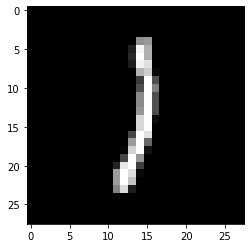

In [ ]:
images, labels = next(iter(test_loader))
plt.imshow(images[0].reshape(28,28), cmap="gray")

images, labels = images.to(device), labels.to(device)
output = model(images)
torch.set_printoptions(precision=3, sci_mode=False)
print(output[0])
pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
label = labels.argmax(dim=1, keepdim=True)  # get the index of the one-hot
print("label =", label[0], "  predicao =", pred[0])

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

# Trainando o modelo

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    running_loss = 0
    batch_size = 100
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.9f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), running_loss / (batch_idx * batch_size)))


In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.mse_loss(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            target_ = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target_).sum().item()

    print('\nTest set: Average loss: {:.9f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss / len(test_loader.dataset), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [ ]:
for epoch in range(10):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

torch.save(model.state_dict(), "mnist_cnn.pt")



Train Epoch: 0 [9900/60000 (16%)]	Loss: 0.000255437
Train Epoch: 0 [19900/60000 (33%)]	Loss: 0.000188938
Train Epoch: 0 [29900/60000 (50%)]	Loss: 0.000162211
Train Epoch: 0 [39900/60000 (66%)]	Loss: 0.000148316
Train Epoch: 0 [49900/60000 (83%)]	Loss: 0.000138569
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.000131218

Test set: Average loss: 0.000080606, Accuracy: 9472/10000 (94.7200%)

Train Epoch: 1 [9900/60000 (16%)]	Loss: 0.000070696
Train Epoch: 1 [19900/60000 (33%)]	Loss: 0.000070204
Train Epoch: 1 [29900/60000 (50%)]	Loss: 0.000069244
Train Epoch: 1 [39900/60000 (66%)]	Loss: 0.000067993
Train Epoch: 1 [49900/60000 (83%)]	Loss: 0.000067970
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.000067582

Test set: Average loss: 0.000069080, Accuracy: 9545/10000 (95.4500%)

Train Epoch: 2 [9900/60000 (16%)]	Loss: 0.000052005
Train Epoch: 2 [19900/60000 (33%)]	Loss: 0.000050407
Train Epoch: 2 [29900/60000 (50%)]	Loss: 0.000049821
Train Epoch: 2 [39900/60000 (66%)]	Loss: 0.000049256
Train Epoch

tensor([    0.000,     0.000,     0.026,     0.000,     0.000,     0.000,
            0.000,     0.955,     0.016,     0.002], device='cuda:0',
       grad_fn=<SelectBackward>)
label = tensor([2], device='cuda:0')   predicao = tensor([7], device='cuda:0')


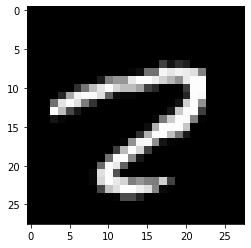

In [ ]:
images, labels = next(iter(test_loader))
plt.imshow(images[0].reshape(28,28), cmap="gray")

images, labels = images.to(device), labels.to(device)
output = model(images)
torch.set_printoptions(precision=3, sci_mode=False)
print(output[0])
pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
label = labels.argmax(dim=1, keepdim=True)  # get the index of the one-hot
print("label =", label[0], "  predicao =", pred[0])